In [14]:
import keras
import os
from deepsense import neptune
from keras_retinanet.bin.train import create_models
from keras_retinanet.callbacks.eval import Evaluate
from keras_retinanet.models.resnet import download_imagenet, resnet_retinanet as retinanet
from keras_retinanet.preprocessing.detgen import DetDataGenerator
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.utils.transform import random_transform_generator
from keras_retinanet.preprocessing.detgen import DetDataGenerator
from detdata import DetGen
from detdata.augmenters import crazy_augmenter
from keras_retinanet.utils.eval import evaluate
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

ctx = neptune.Context()

detg= DetGen('/home/i008/malaria_data/dataset_train.mxrecords',
      '/home/i008/malaria_data/dataset_train.csv',
      '/home/i008/malaria_data/dataset_train.mxindex', batch_size=4)


train_generator = DetDataGenerator(detg, augmenter=crazy_augmenter)
train_generator.image_max_side = 750
train_generator.image_min_side = 750




weights = download_imagenet('resnet50')

model_checkpoint = keras.callbacks.ModelCheckpoint('mod-{epoch:02d}_loss-{loss:.4f}.h5',
                                                   monitor='loss',
                                                   verbose=2,
                                                   save_best_only=False,
                                                   save_weights_only=False,
                                                   mode='auto',
                                                   period=1)

callbacks = []


class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        ctx.channel_send("loss", logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        ctx.channel_send("val_loss", logs.get('val_loss'))


callbacks.append(keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=2,
    verbose=1,
    mode='auto',
    epsilon=0.0001,
    cooldown=0,
    min_lr=0
))

# callbacks.append(LossHistory())
callbacks.append(model_checkpoint)

model, training_model, prediction_model = create_models(
    backbone_retinanet=retinanet,
    backbone='resnet50',
    num_classes=train_generator.num_classes(),
    weights=weights,
    multi_gpu=0,
    freeze_backbone=True
)

# training_model.fit_generator(
#     generator=train_generator,
#     steps_per_epoch=5000,
#     epochs=100,
#     verbose=1,
#     callbacks=callbacks,
# )

neptune: Executing in Offline Mode.


In [2]:
# training_model.fit_generator(
#     generator=train_generator,
#     steps_per_epoch=5000,
#     epochs=100,
#     verbose=1,
#     callbacks=callbacks,
# )

In [19]:
model.load_weights('mod-40_loss-2.0113.h5')

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('/home/i008/malaria_data/dataset_train.csv')
df = df[['fname','xmin','ymin','xmax','ymax','class_name']]
df['fname'] = '/home/i008/googledrive/Projects/malaria/malaria_dataset/' + df.fname 
df.to_csv('csvitertrain.csv', header=False, index=False)

In [8]:
%%writefile cls.csv
Malaria, 0

Overwriting cls.csv


In [20]:
g = CSVGenerator('csviterval.csv', 'cls.csv')
x, y =g.next()
model.predict(x)

[array([[[ 0.77843237,  0.88179201, -0.39568624, -0.12024883],
         [ 0.77255142,  0.94349009, -0.48530662, -0.16200781],
         [ 0.57146406,  0.93402553, -0.84362429,  0.35413888],
         ..., 
         [-0.11196241, -0.16095227,  0.0993282 , -0.07307471],
         [-0.14613849, -0.14316392,  0.04777076, -0.11493397],
         [-0.14815781, -0.16174443,  0.03175341, -0.12969147]]], dtype=float32),
 array([[[ 0.01316346],
         [ 0.01271749],
         [ 0.01185289],
         ..., 
         [ 0.01042768],
         [ 0.01042996],
         [ 0.01031132]]], dtype=float32),
 array([[[   0.        ,    0.        ,   28.42854881,   17.04012871],
         [   0.        ,    0.        ,   34.2766037 ,   20.48968887],
         [   0.        ,    0.        ,   38.44734192,   26.63245392],
         ..., 
         [ 643.29516602,  463.55981445,  800.        ,  800.        ],
         [ 595.07452393,  373.16491699,  800.        ,  800.        ],
         [ 534.30432129,  253.42358398,  8

In [43]:
# average_precisions, recall, precision, true_positives, false_positives = evaluate(g, model, score_threshold=0.1)
average_precisions

{0: 0.76875487986135504}

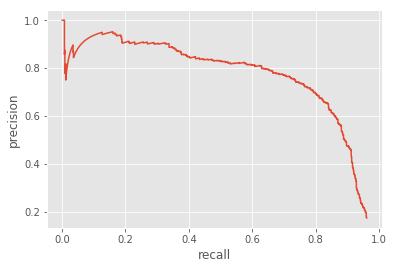

In [41]:
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')

plt.style.use('ggplot')
import seaborn as sns

In [36]:
true_positives / max(true_positives)

array([ 0.00140647,  0.00281294,  0.00421941, ...,  1.        ,
        1.        ,  1.        ])

Text(0,0.5,'detection rate (true positives)')

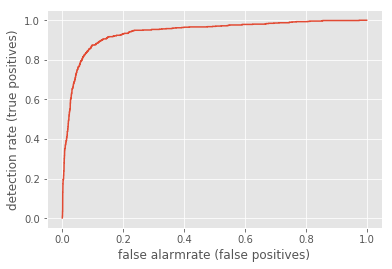

In [42]:
plt.plot(false_positives/max(false_positives), true_positives/max(true_positives))
plt.xlabel("false alarmrate (false positives)")
plt.ylabel("detection rate (true positives)")

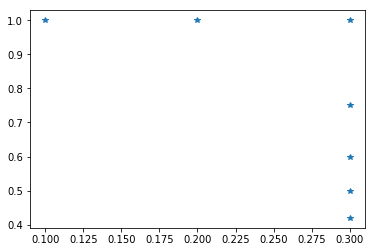

In [7]:
precisions = [1, 1, 1, 0.75, 0.6, 0.5, 0.42]
recalls = [0.1, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3]

plt.plot(recalls, precisions, '*')

In [19]:
import numpy as np
sorted_detections = np.array([0.6, 0.5, 0.49, 0.3, 0.2, 1.5, 0.1, 0.09, 0.05, 0.01, 0.01] )
sorted_detections_simplify = [1] * 11
positives = np.array([1,1,1,0,0,0,0,0,0,0,1])
assert len(sorted_detections_simplify) == len(positives)



all_true = sum(positives)
correct_detectio = 0
R = []
P = []
for i, (det, true) in enumerate(zip(sorted_detections_simplify, positives)):
    i+=1
    i=i * 1.0
    
    if det == true:
        correct_detectio+=1
    precision = correct_detectio / i
    recall = correct_detectio / len(positives)
    print("top {} recall={}  precision={}".format(i, recall, precision))
    R.append(recall)
    P.append(precision)
    
    
    

top 1.0 recall=0.09090909090909091  precision=1.0
top 2.0 recall=0.18181818181818182  precision=1.0
top 3.0 recall=0.2727272727272727  precision=1.0
top 4.0 recall=0.2727272727272727  precision=0.75
top 5.0 recall=0.2727272727272727  precision=0.6
top 6.0 recall=0.2727272727272727  precision=0.5
top 7.0 recall=0.2727272727272727  precision=0.42857142857142855
top 8.0 recall=0.2727272727272727  precision=0.375
top 9.0 recall=0.2727272727272727  precision=0.3333333333333333
top 10.0 recall=0.2727272727272727  precision=0.3
top 11.0 recall=0.36363636363636365  precision=0.36363636363636365


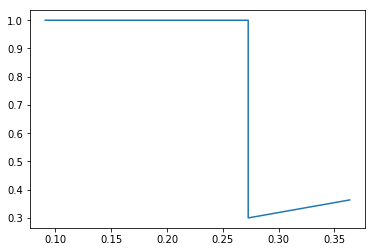

In [21]:
plt.plot(R, P)